# Predicting Real or fake news


# 1.Problem Definion

>Given a information about news , can we predict whether the news is real or fake ?


# 2.Data

The original data come from https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

# 3.Evaluation

>If we can reach  >=90% accuracy of predicting whether the news is real or fake during the proof concept, we'll pursue the project

# 4.Features
**Data Dictionary**

News.Csv:
* First column : Identifies the news,
* Second col : Title
* Third col : Text,
* Fourth col : Labels denoting whether the news is REAL or FAKE.

News.Csv :
* Shape : 7796×4
* Space : 29.2MB

**Create variable of data dictionary**

In [1]:
data_dict ={
 'First column' : 'Identifies the news',
 'Second col' : 'Title',
 'Third col': 'Text',
 'Fourth col' : 'Labels denoting whether the news is REAL or FAKE.'
}

### Preparing basic tools


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


**Load the data**

In [3]:
df = pd.read_csv('Data/news.csv')

## Data exploration (Exploratory data analysis)

The key is to be subjet matter on our exploration

In [4]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [8]:
df.dtypes

Unnamed: 0     int64
title         object
text          object
label         object
dtype: object

We need to convert our data to numerical value

In [9]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [10]:
#Comparing the real and fake label
df['label'].value_counts()


REAL    3171
FAKE    3164
Name: label, dtype: int64

<AxesSubplot:title={'center':'Real vs Fake'}>

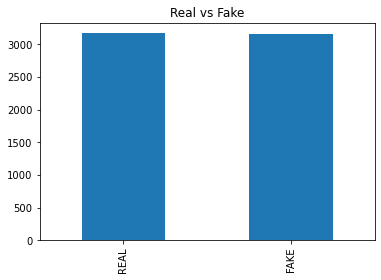

In [11]:
#Visualize comparison
df['label'].value_counts().plot(kind='bar',
                                title='Real vs Fake')

# 5.Modeling

## 1.Get the data ready

Since our data haven't on numerical value, 

let's get the data ready with these following step:
1. Splitting
2. Converting with OneHot Encoder

In [12]:
# Preparing tools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


In [13]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### Splitting our data

In [14]:
#Split into features and label
X= df['text'] # I have no idea why we can't use the entire columns
y= df['label']

#Split into train test set
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2)

### Converting our data to num value with TfidfVectorizer

In [15]:
tfidf = TfidfVectorizer(stop_words='english', )

tfidf_X_train = tfidf.fit_transform(X_train)

tfidf_X_test = tfidf.transform(X_test)

## 2.Pick Up Model  
What are we going to use is text classification model which are not exist on sklearn machine learning map

Let's try:
* PassiveAggresiveClassifier()
* SGDClassifier()
* MultiNomialNB()
* SVC()

In [16]:
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC


models = {
    'Pass_Agg': PassiveAggressiveClassifier(),
    'Multi_nomial': MultinomialNB(),
    'SVC': SVC(),
    'SGD': SGDClassifier()
 }
model_score = {}
    
for name,model in models.items():
    
    np.random.seed(42)
    
  
    #Fit model
    model.fit(X=tfidf_X_train, 
              y= y_train)
    
    #Create new key['Name'] with value model score
    model_score[name] = model.score(tfidf_X_test, y_test)
   

In [17]:
model_score

{'Pass_Agg': 0.9376479873717443,
 'Multi_nomial': 0.8453038674033149,
 'SVC': 0.930544593528019,
 'SGD': 0.9384372533543804}

## 3.Improve model
The highest score accuracy is PassiveAggreziveClassifier and SGDClassifier, let's try improve them with tune the hyperparam

### 3.1.Tune PassiveAggressiveClassifier

In [18]:
np.random.seed(42)
pass_agg = PassiveAggressiveClassifier()

#Create grid
pass_agg_grid ={
    'validation_fraction':[0.1,0.2,0.3,0.4,0.5],
    'class_weight': ['balanced', None]
}

#Instantiate gs pass_agg
gs_pass_agg = GridSearchCV(pass_agg,
                           param_grid=pass_agg_grid,
                           cv=5,
                          verbose=True)

#Fit the model to data
gs_pass_agg.fit(tfidf_X_train, y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=PassiveAggressiveClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'validation_fraction': [0.1, 0.2, 0.3, 0.4, 0.5]},
             verbose=True)

In [19]:
print(f'The highest score is: {gs_pass_agg.score(tfidf_X_test, y_test)}')
print(f'The best params is: {gs_pass_agg.best_params_}')

The highest score is: 0.9352801894238358
The best params is: {'class_weight': 'balanced', 'validation_fraction': 0.4}


Since there is no improvement, Let's tune another model

### Tune SGDClassifier hyperparameter

In [20]:

params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"]

SyntaxError: unexpected EOF while parsing (<ipython-input-20-1533a364a0b9>, line 4)

In [21]:
sgd = SGDClassifier(max_iter= 1000)

sgd_grid = {
    'loss' : ['hinge', 'log', "squared_hinge"],
    'alpha' : [0.01, 0.1,0.0001, 0.001,],
    'penalty': ['none',"l2", "l1",]
}

gs_sgd = GridSearchCV(sgd,
                     param_grid= sgd_grid,
                     cv=5,
                     verbose=True)

gs_sgd.fit(tfidf_X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\ROG\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
C:\Users\ROG\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': [0.01, 0.1, 0.0001, 0.001],
                         'loss': ['hinge', 'log', 'squared_hinge'],
                         'penalty': ['none', 'l2', 'l1']},
             verbose=True)

In [22]:
print(f'The best score is: {gs_sgd.score(tfidf_X_test, y_test)}')
print(f'The best param is: {gs_sgd.best_params_}')

The best score is: 0.936069455406472
The best param is: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'none'}


Since after we tuned the hyperparam of our model and still did'nt see any improvement,

The final model will be basic `SGDClassifier`

## 5.Evaluation Model

We're going evaluate our model with:
* Problem specific metrics:
1. Plot ROC Curve
2. AUC score
3. Classification Report
4. Confusion matrix

* The scoring parameter:
1. Accuracy
2. Precision
3. Recall
4. F1 score

In [25]:
#Import for the scoring parameter
from sklearn.model_selection import cross_val_score

#Import for problem specific metrics
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [42]:
np.random.seed(42)
#Instantiate model
sgd = SGDClassifier()

#fit the model to data and use it to make prediction
sgd.fit(tfidf_X_train, y_train)

y_preds = sgd.predict(tfidf_X_test)


### Plot ROC Curve and AUC score

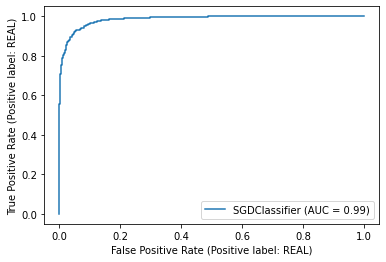

In [43]:
plot_roc_curve(sgd ,tfidf_X_test, y_test)

### Classification report

In [44]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

        FAKE       0.93      0.95      0.94       628
        REAL       0.95      0.93      0.94       639

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267



 ### Confusion Matrix
Let's see where our model getting confused

We also see TPR,FPR to implement on our data

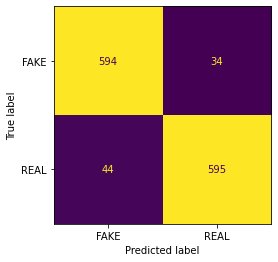

In [45]:
plot_confusion_matrix(sgd, tfidf_X_test, y_test ,
                     colorbar=False)

In [49]:
print(f'The final score is {sgd.score(tfidf_X_test, y_test)* 100:.2f}%')

The final score is 93.84%


We've done our project,

we've learned:
1. How to predict fake news using pyhton,
2. How to transform text data into number using features extracition(TfidfVectorizer, CountVectorizer)
* Note: When vectorizer  We can't you two columns when split into Features and label

3. How to evaluate text model(PassiveAggresiveClassifier, SGDClassifier etc)
4. We recap what we've learned before

Final score is  SGDClassifier with 93.84%